In [1]:
from typing import Annotated

from typing_extensions import TypedDict
from rapid_law.components.pinecone_utils import pinecone_query
from rapid_law.components.cohere_utils import cohere_text_generation, cohere_rerank
from rapid_law.components.ollama_utils import ollama_text_generation
from rapid_law.components.gemini_utils import gemini_text_generation
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import xml.etree.ElementTree as ET

/Users/snehvora/Desktop/rapid_law/.venv/lib/python3.10/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    docs: list[dict]
    prompt: str

In [3]:
def data_retrieval(state: State):
    print('START')
    response = pinecone_query("rapid-laws",state["messages"][0].content,top_k=10)
    print('p1')
    docs = [matches['metadata'] for matches in response['matches']]
    print(docs)
    print('-'*50)
    return {"docs":docs}

In [4]:
def rerank(state: State):
    docs = cohere_rerank(query=state["messages"][-1].content,docs=state["docs"])
    print(docs)
    print('-'*50)
    return {"docs":docs}


In [5]:
def format_to_xml(data : list[dict]):
    root = ET.Element("documents")

    # Populate the XML
    for item in data:
        doc = ET.SubElement(root, "document")
        ET.SubElement(doc, "chapter").text = item['chapter']
        ET.SubElement(doc, "title").text = item['title']
        ET.SubElement(doc, "subchapter").text = item['subchapter']
        ET.SubElement(doc, "section").text = item['section']
        
        section_content = ET.SubElement(doc, "section_content")
        paragraphs = item['section_content'].split('  ')
        for para in paragraphs:
            if para.strip():
                ET.SubElement(section_content, "paragraph").text = para.strip()
        
        ET.SubElement(doc, "url").text = item['url']

    # Convert to XML string
    xml_str = ET.tostring(root, encoding='unicode', method='xml')

    # Print the XML string
    return str(xml_str)

In [6]:
def prompt_generation(state: State):
    context = format_to_xml(state["docs"])
    prompt = f"""
    Act as a legal expert and provide a factual answer to the following question based on the provided documents.
    You have access to an XML document containing details about bankruptcy law. The document is structured as follows:
    {context}

    Task:

    Extract Relevant Information: Use the paragraphs within section_content from the XML document to answer the following question:
    Question:  {state["messages"][-1].content}
    Format Your Response: If the answer is not contained within the documents, respond with "I don't know." If the user greets you, reply accordingly by ignoring the provided documents.
    Citation Format: When citing information from the documents, include the title, chapter, and subchapter with the link embedded in the title.
    Response Format:

    Your answer should be formatted in markdown and include a citation as follows:

    Answer: [Provide the answer here]
    Citation: Title, Chapter [Chapter Number], Subchapter [Subchapter Number]
    """

    print(prompt)
    print('-'*50)
    return {"prompt":str(prompt)}

In [7]:
def llm_node(state: State):
    print(state['prompt'])
    # response = gemini_text_generation(query=state['prompt'])
    # response = ollama_text_generation(query=state['prompt'],model_name='phi3')
    response = cohere_text_generation(query=state['prompt'])
    return {"messages": str(response)}
    

In [8]:
graph_builder = StateGraph(State)

graph_builder.add_node("data_retrieval", data_retrieval)
graph_builder.add_node("rerank", rerank)
graph_builder.add_node("prompt_generation", prompt_generation)
graph_builder.add_node("llm_node", llm_node)

graph_builder.add_edge(START, "data_retrieval")
graph_builder.add_edge("data_retrieval", "rerank")
graph_builder.add_edge("rerank", "prompt_generation")
graph_builder.add_edge("prompt_generation", "llm_node")
graph_builder.add_edge("llm_node", END)

graph = graph_builder.compile()



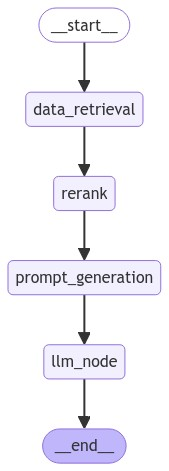

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
final_state = graph.invoke(
    {"messages": ("user", "After her petition for a composition or extension of her debts in farmer-debtor proceeding under 75 of the [317 U.S. 325, 326] Bankruptcy Act, 11 U.S.C. 203, 11 U.S.C.A. 203, had been dismissed, petitioner applied to reopen the proceeding or, in the alternative, to be permitted to institute a new proceeding under 75. The questions for our decision are whether the courts below erred in denying her application and whether, at the time of her application, her right as mortgagor to redeem Alabama real estate after its sale on foreclosure of the mortgage was such that it can be administered by the court in a 75 proceeding.In 1937, after respondent mortgagee had obtained a decree of foreclosure, but before foreclosure sale, petitioner filed a petition under 75 seeking a composition or extension of her debts. The bankruptcy court referred the proceeding to a conciliation commissioner; petitioner filed proposed terms of composition or extension to which respondent filed objections; the conciliation commissioner then recommended that the offer be not approved on the ground that it did not contain an equitable and feasible method of liquidating respondent's claim and of securing petitioner's financial rehabilitation.")}
)

START
{'matches': [{'id': '107',
              'metadata': {'chapter': 'Chapter 3—Case Administration (§§ 301 – '
                                      '366)',
                           'section': '§\u202f349. Effect of dismissal',
                           'section_content': ' (a)  Unless the court, for '
                                              'cause, orders otherwise, the '
                                              'dismissal of a case under this '
                                              'title does not bar the '
                                              'discharge, in a later case '
                                              'under this title, of debts that '
                                              'were dischargeable in the case '
                                              'dismissed; nor does the '
                                              'dismissal of a case under this '
                                              'title prejudice the deb

In [11]:
final_state['messages'][-1].content

"Answer: I can provide information on the process of reopening a bankruptcy case, but I need clarification on the specific details of the petitioner's situation to give a precise answer. \n\nIn general, a bankruptcy case can be reopened [Title 11 - Bankruptcy, Chapter 3—Case Administration, Subchapter Iii—Administration]:\n\n> A case may be reopened in the court in which such case was closed to administer assets, to accord relief to the debtor, or for other cause. [§\u202f350. Closing and reopening cases]\n\nCitation: Title 11 - Bankruptcy, Chapter 3—Case Administration [3], Subchapter Iii—Administration [III]"